In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2.VGG19 

In [2]:
import os
import cv2
import imageio
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Activation
import shutil
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff

%matplotlib inline

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob

In [4]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [5]:
!pip install scikit-plot

In [6]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [7]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
fid = drive.ListFile({'q':"title='imagecovid.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('imagecovid.zip')

In [9]:
!unzip imagecovid.zip

Streaming output truncated to the last 5000 lines.
  inflating: imagecovid/Normal/Normal-1929.png  
  inflating: imagecovid/Normal/Normal-193.png  
  inflating: imagecovid/Normal/Normal-1930.png  
  inflating: imagecovid/Normal/Normal-1931.png  
  inflating: imagecovid/Normal/Normal-1932.png  
  inflating: imagecovid/Normal/Normal-1933.png  
  inflating: imagecovid/Normal/Normal-1934.png  
  inflating: imagecovid/Normal/Normal-1935.png  
  inflating: imagecovid/Normal/Normal-1936.png  
  inflating: imagecovid/Normal/Normal-1937.png  
  inflating: imagecovid/Normal/Normal-1938.png  
  inflating: imagecovid/Normal/Normal-1939.png  
  inflating: imagecovid/Normal/Normal-194.png  
  inflating: imagecovid/Normal/Normal-1940.png  
  inflating: imagecovid/Normal/Normal-1941.png  
  inflating: imagecovid/Normal/Normal-1942.png  
  inflating: imagecovid/Normal/Normal-1943.png  
  inflating: imagecovid/Normal/Normal-1944.png  
  inflating: imagecovid/Normal/Normal-1945.png  
  inflating: imageco

In [10]:
COVID_PATH = '/content/imagecovid/Covid'
NORMAL_PATH = '/content/imagecovid/Normal'
PNEUMONIA_PATH = '/content/imagecovid/Pneomonia'

In [11]:
def img_preprocessing(image_path):
    img = cv2.imread(image_path, 0)
    org_img = img.copy()
    brightest = np.max(img)
    darkest = np.min(img)
    T = darkest + 0.9*(brightest - darkest)
    thre_img = cv2.threshold(img, T, 255, cv2.THRESH_BINARY)
    thre_img = thre_img[1]
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.erode(thre_img, kernel, iterations = 5)
    cleaned = cv2.dilate(cleaned, kernel, iterations = 5)
    cleaned = cleaned//255
    img = img * cleaned
    img = org_img - img
    dim = (224, 224)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    B = cv2.bilateralFilter(img, 9, 75, 75)
    R = cv2.equalizeHist(img)
    new_img = cv2.merge((B, img, R))
    return new_img

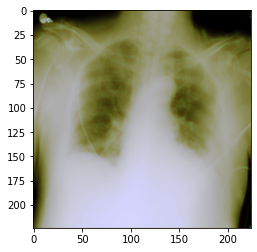

In [12]:
img = img_preprocessing(COVID_PATH + '/COVID-1.png')
plt.imshow(img)

In [13]:
base_dir = 'base_dir'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
COVID = os.path.join(train_dir, 'COVID')
os.mkdir(COVID)
Viral_Pneumonia = os.path.join(train_dir, 'Viral_Pneumonia')
os.mkdir(Viral_Pneumonia)
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
COVID = os.path.join(val_dir, 'COVID')
os.mkdir(COVID)
Viral_Pneumonia = os.path.join(val_dir, 'Viral_Pneumonia')
os.mkdir(Viral_Pneumonia)
Normal = os.path.join(test_dir, 'Normal')
os.mkdir(Normal)
COVID = os.path.join(test_dir, 'COVID')
os.mkdir(COVID)
Viral_Pneumonia = os.path.join(test_dir, 'Viral_Pneumonia')
os.mkdir(Viral_Pneumonia)

In [14]:
folder_1 = os.listdir(COVID_PATH)
folder_1 = shuffle(folder_1)
folder_2 = os.listdir(NORMAL_PATH)
folder_2 = shuffle(folder_2)
folder_3 = os.listdir(PNEUMONIA_PATH)
folder_3 = shuffle(folder_3)

In [15]:
covid_data = pd.DataFrame(folder_1, columns = ['FILE NAME'])
normal_data = pd.DataFrame(folder_2, columns = ['FILE NAME'])
pneumonia_data = pd.DataFrame(folder_3, columns = ['FILE NAME'])
covid_data['Target'] = 'COVID'
normal_data['Target'] = 'Normal'
pneumonia_data['Target'] = 'Viral_Pneumonia'
covid_data['Labels'] = '0'
normal_data['Labels'] = '1'
pneumonia_data['Labels'] = '2'
data = pd.concat([covid_data, normal_data, pneumonia_data], axis = 0, sort = False)
data

,FILE NAME,Target,Labels
0,COVID-2828.png,COVID,0
1,COVID-1454.png,COVID,0
2,COVID-401.png,COVID,0
3,COVID-1521.png,COVID,0
4,COVID-560.png,COVID,0
...,...,...,...
3011,person826_virus_1462.jpeg,Viral_Pneumonia,2
3012,person707_bacteria_2606.jpeg,Viral_Pneumonia,2
3013,person1158_virus_1940.jpeg,Viral_Pneumonia,2
3014,person294_virus_611.jpeg,Viral_Pneumonia,2


In [16]:
y1 = data['Labels']

In [17]:
y1.shape

(9048,)

In [18]:
y1 = data['Labels']
df_train, df_val_test = train_test_split(data, test_size=0.3, random_state=101, stratify = y1)
y2 = df_val_test['Labels']
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=101, stratify = y2)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
df_train[100:120]

(6333, 3)
(1357, 3)
(1358, 3)


,FILE NAME,Target,Labels
651,COVID-862.png,COVID,0
1602,COVID-2158.png,COVID,0
2954,Normal-1135.png,Normal,1
800,Normal-1521.png,Normal,1
1569,COVID-832.png,COVID,0
2021,person849_bacteria_2770.jpeg,Viral_Pneumonia,2
2561,COVID-291.png,COVID,0
2902,Normal-1013.png,Normal,1
86,Normal-1635.png,Normal,1
2775,COVID-963.png,COVID,0


In [19]:
data.set_index('FILE NAME', inplace = True)
data

,Target,Labels
FILE NAME,,
COVID-2828.png,COVID,0
COVID-1454.png,COVID,0
COVID-401.png,COVID,0
COVID-1521.png,COVID,0
COVID-560.png,COVID,0
...,...,...
person826_virus_1462.jpeg,Viral_Pneumonia,2
person707_bacteria_2606.jpeg,Viral_Pneumonia,2
person1158_virus_1940.jpeg,Viral_Pneumonia,2


In [20]:
# Get a list of train and val images
train_list = list(df_train['FILE NAME'])
val_list = list(df_val['FILE NAME'])
test_list = list(df_val['FILE NAME'])

In [21]:
# Transfer the train images

for image in train_list:
    fname = image
    label = data.loc[image,'Target']
    if fname in folder_1:
        src = os.path.join(COVID_PATH, fname)
        dst = os.path.join(train_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

for image in val_list:
    fname = image
    label = data.loc[image,'Target']
    if fname in folder_1:
        src = os.path.join(COVID_PATH, fname)
        dst = os.path.join(val_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)
        
for image in test_list:
    fname = image 
    label = data.loc[image,'Target']
    if fname in folder_1:
        src = os.path.join(COVID_PATH, fname)
        dst = os.path.join(test_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

In [22]:
for image in train_list:

    fname = image
    label = data.loc[image,'Target']
    if fname in folder_2:
        src = os.path.join(NORMAL_PATH, fname)
        dst = os.path.join(train_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

for image in val_list:
    fname = image
    label = data.loc[image,'Target']
    if fname in folder_2:
        src = os.path.join(NORMAL_PATH, fname)
        dst = os.path.join(val_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)
        
for image in test_list:
    fname = image 
    label = data.loc[image,'Target']
    if fname in folder_2:
        src = os.path.join(NORMAL_PATH, fname)
        dst = os.path.join(test_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

In [23]:
for image in train_list:
    fname = image
    label = data.loc[image,'Target']
    if fname in folder_3:
        src = os.path.join(PNEUMONIA_PATH, fname)
        dst = os.path.join(train_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

for image in val_list:
    fname = image 
    label = data.loc[image,'Target']
    if fname in folder_3:
        src = os.path.join(PNEUMONIA_PATH, fname)
        dst = os.path.join(val_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)
        
for image in test_list:
    fname = image 
    label = data.loc[image,'Target']
    if fname in folder_3:
        src = os.path.join(PNEUMONIA_PATH, fname)
        dst = os.path.join(test_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

In [24]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/COVID')))
print(len(os.listdir('base_dir/val_dir/COVID')))
print(len(os.listdir('base_dir/train_dir/Viral_Pneumonia')))
print(len(os.listdir('base_dir/val_dir/Viral_Pneumonia')))

2111
452
2111
452
2111
453


In [25]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'base_dir/test_dir'

In [26]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/COVID')))
print(len(os.listdir('base_dir/val_dir/COVID')))
print(len(os.listdir('base_dir/train_dir/Viral_Pneumonia')))
print(len(os.listdir('base_dir/val_dir/Viral_Pneumonia')))

2111
452
2111
452
2111
453


In [27]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'base_dir/test_dir'

In [28]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [29]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,
                                        class_mode='categorical', shuffle=False)

Found 6333 images belonging to 3 classes.
Found 1357 images belonging to 3 classes.
Found 1357 images belonging to 3 classes.


In [30]:
# add preprocessing layer to the front of VGG
IMAGE_SIZE = [224,224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 0s 0us/step


In [31]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [32]:
  # useful for getting number of classes
folders = glob('/content/base_dir/train_dir/*')

In [33]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [34]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [35]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [37]:
# fit the model
r = model.fit_generator(
  train_gen,
  validation_data=test_gen,
  epochs=100,
  steps_per_epoch=len(train_gen),
  validation_steps=len(test_gen)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/100
198/198 [==============================] - 32s 118ms/step - loss: 0.3351 - accuracy: 0.8806 - val_loss: 0.1779 - val_accuracy: 0.9344
Epoch 2/100
198/198 [==============================] - 22s 112ms/step - loss: 0.1092 - accuracy: 0.9621 - val_loss: 0.1101 - val_accuracy: 0.9632
Epoch 3/100
198/198 [==============================] - 22s 111ms/step - loss: 0.0705 - accuracy: 0.9758 - val_loss: 0.0977 - val_accuracy: 0.9668
Epoch 4/100
198/198 [==============================] - 22s 112ms/step - loss: 0.0428 - accuracy: 0.9875 - val_loss: 0.0944 - val_accuracy: 0.9690
Epoch 5/100
198/198 [==============================] - 22s 111ms/step - loss: 0.0289 - accuracy: 0.9934 - val_loss: 0.1226 - val_accuracy: 0.9528
Epoch 6/100
198/198 [==============================] - 22s 112ms/step - loss: 0.0350 - accuracy: 0.9897 - val_loss: 0.1011 - val_accuracy: 0.9654
Epoch 7/100
198/198 [==============================] - 22s 111ms/step - loss: 0.0298 - accuracy: 0.9904 - val_loss: 0.1162 -

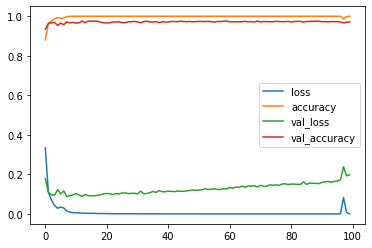

In [38]:
pd.DataFrame(r.history).plot()

In [39]:
preds = model.evaluate(val_gen)
print ("Validation Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))

43/43 [==============================] - 4s 91ms/step - loss: 0.1980 - accuracy: 0.9713
Validation Loss = 0.19803518056869507
Validation Accuracy = 0.971260130405426


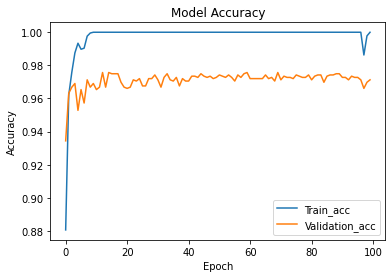

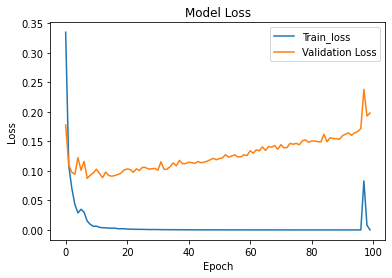

In [40]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train_acc","Validation_acc"])
plt.show()

plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train_loss","Validation Loss"])
plt.show()

In [41]:
test_accu = model.evaluate(
test_gen)
print('The testing accuracy is :',test_accu[1]*100, '%')

43/43 [==============================] - 4s 91ms/step - loss: 0.1980 - accuracy: 0.9713
The testing accuracy is : 97.1260130405426 %


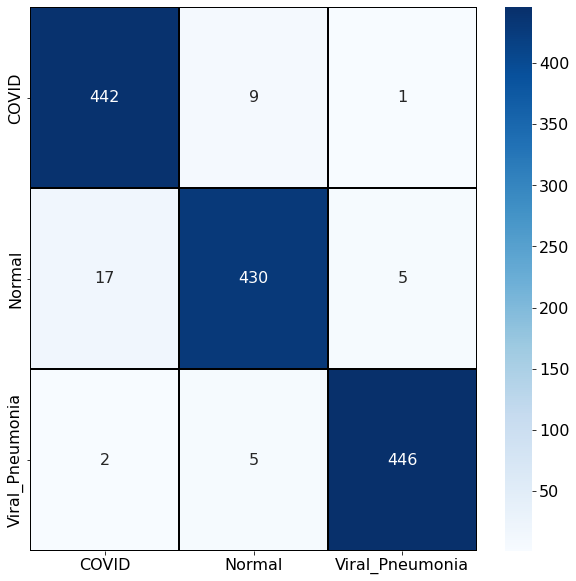

In [42]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
plt.rcParams.update({'font.size': 16})
predictions = model.predict(test_gen)
predictions = np.argmax(predictions,axis=1)
predictions[:15]
cm = confusion_matrix(test_gen.classes, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2'], columns = ['0', '1', '2'])
cm
class_names = ['COVID','Normal','Viral_Pneumonia']

def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_gen.classes,  predictions)
print(cm)

[[442   9   1]
 [ 17 430   5]
 [  2   5 446]]


In [44]:
#confusion matrx 
y_pred = model.predict_generator(test_gen, steps=len(test_gen), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = test_gen.classes
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

 1/43 [..............................] - ETA: 4s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



43/43 [==============================] - 4s 88ms/step


In [45]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       452
           1       0.97      0.95      0.96       452
           2       0.99      0.98      0.99       453

    accuracy                           0.97      1357
   macro avg       0.97      0.97      0.97      1357
weighted avg       0.97      0.97      0.97      1357



In [46]:
#Let's plot ROC & AUC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
all_labels = ['COVID-19','NORMAL','Viral_Pneumonia']

0.9784416241087133

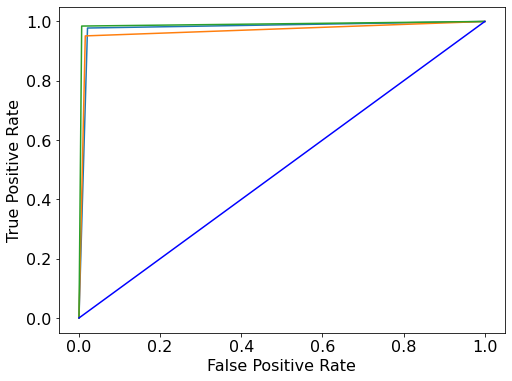

In [47]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (8, 6))

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
#true_concat.reset() # resetting generator
#y_pred = model.predict_generator(y_test, verbose = True)
#y_pred = np.argmax(y_pred, axis=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
multiclass_roc_auc_score(y_true, y_pred)

In [54]:
fid = drive.ListFile({'q':"title='Unseen_data.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Unseen_data.zip')

In [55]:
!unzip Unseen_data.zip

Archive:  Unseen_data.zip
   creating: Unseen_data/Covid/
  inflating: Unseen_data/Covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg  
  inflating: Unseen_data/Covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg  
  inflating: Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png  
  inflating: Unseen_data/Covid/23E99E2E-44

In [57]:
###VGG with augumentation 
from keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

#  Normal_test(out of 10 8 were normal

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



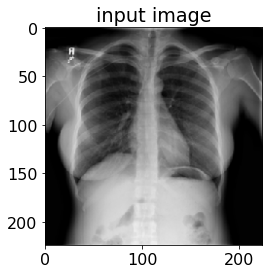

In [58]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10191.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



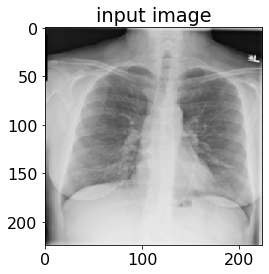

In [59]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10172.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



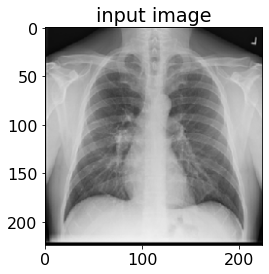

In [60]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10173.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



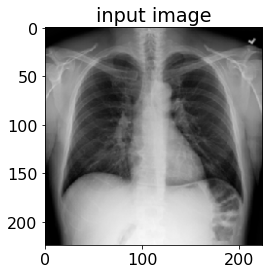

In [61]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10174.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



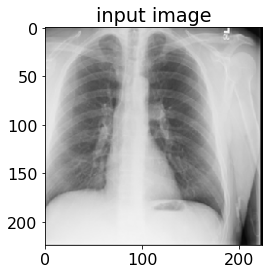

In [62]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10175.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 6.801585227417158e-29 percent



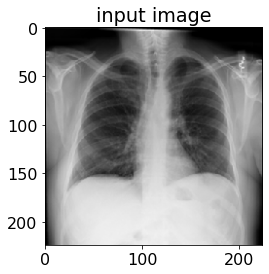

In [63]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10176.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



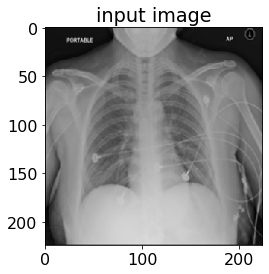

In [64]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10177.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



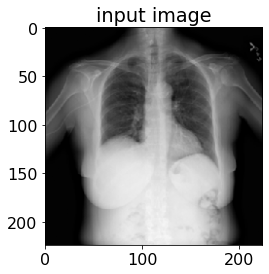

In [65]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10178.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



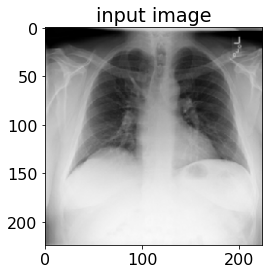

In [66]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10179.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



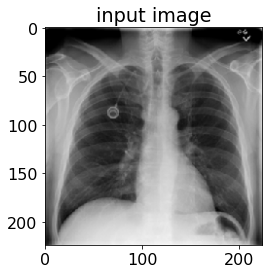

In [67]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10180.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

#pneomonia_test(out of 10 10 were normal

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



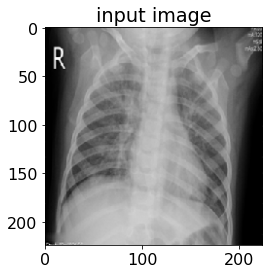

In [68]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-1.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 99.96592998504639 percent

The chances of image being Viral_Pneumonia is : 0.034070725087076426 percent



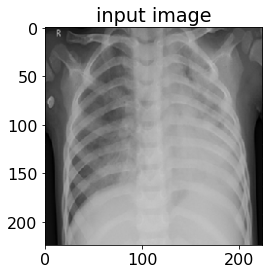

In [69]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-10.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



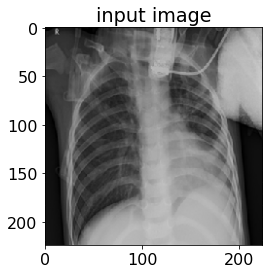

In [70]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-11.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



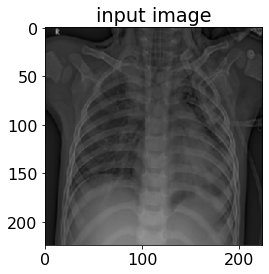

In [71]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-12.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



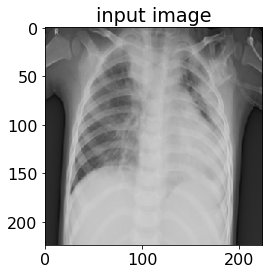

In [72]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-13.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



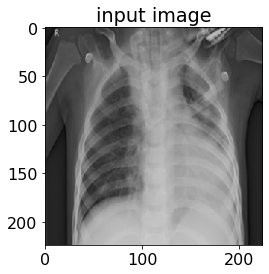

In [73]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-14.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



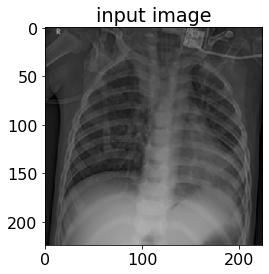

In [74]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-15.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



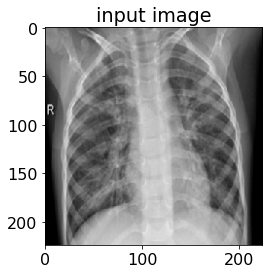

In [75]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-16.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



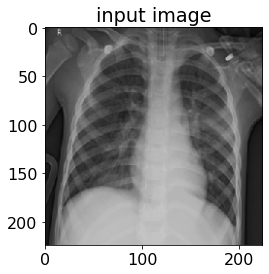

In [76]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-17.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



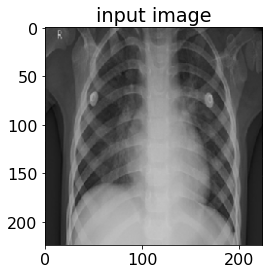

In [77]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-18.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()


Covid_test(out of 10 5

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



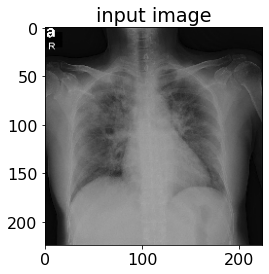

In [78]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



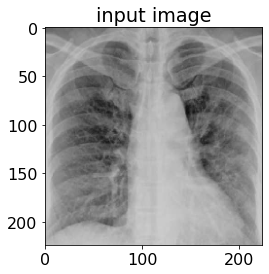

In [79]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/1-s2.0-S1684118220300608-main.pdf-001.jpg'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 3.6018443002466816e-10 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



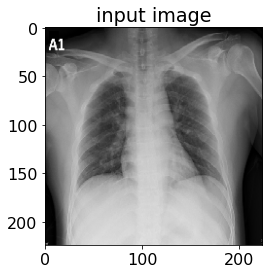

In [80]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 3.6018443002466816e-10 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



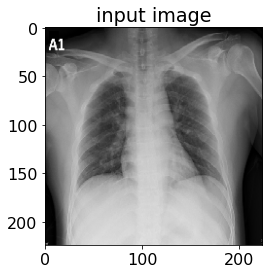

In [81]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



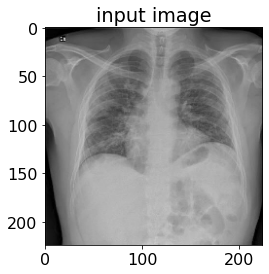

In [82]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



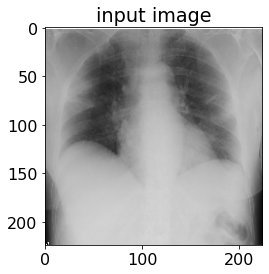

In [83]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



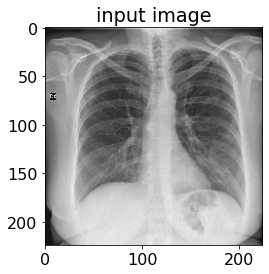

In [84]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/23E99E2E-447C-46E5-8EB2-D35D12473C39.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



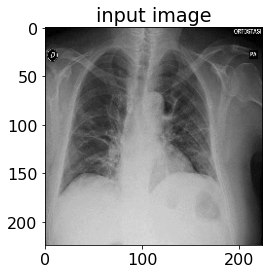

In [85]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



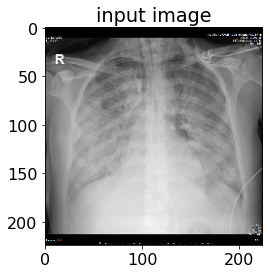

In [86]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/31BA3780-2323-493F-8AED-62081B9C383B.jpeg'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



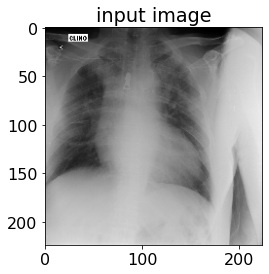

In [87]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Covid/7AF6C1AF-D249-4BD2-8C26-449304105D03.jpeg'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()